# 🎯 Notebook 03: Status da Modelagem Prática

**Objetivo:** Checkpoint rápido do projeto ML para direcionar esforços práticos. Carrega datasets train/test (NB02B stratified split), valida baseline Random Forest no test set, documenta features/performance/limitações, estabelece métricas de sucesso realistas para 1 mês.

**Não é:** Análise exploratória profunda (já feita em NB01/02). **É:** Status atual + plano de ação executável com deadline contrato (1 mês até início Dez/2025).

---

## 🔧 Setup: Imports e Configurações

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports completos")

✅ Imports completos


## 📂 Parte 1: Carregamento de Dados

Carregar datasets train/test criados no notebook 02 com features agregadas.

In [2]:
# Paths - USANDO STRATIFIED SPLIT (corrigido, sem data leakage)
data_dir = Path('../data')
train_path = data_dir / 'device_features_train_stratified.csv'
test_path = data_dir / 'device_features_test_stratified.csv'

# Validar existência
assert train_path.exists(), f"❌ Train set não encontrado: {train_path}"
assert test_path.exists(), f"❌ Test set não encontrado: {test_path}"

# Carregar
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print(f"✅ Train set: {df_train.shape[0]} devices, {df_train.shape[1]} features")
print(f"✅ Test set: {df_test.shape[0]} devices, {df_test.shape[1]} features")
print(f"\n📊 Total dataset: {df_train.shape[0] + df_test.shape[0]} devices")

✅ Train set: 552 devices, 35 features
✅ Test set: 237 devices, 35 features

📊 Total dataset: 789 devices


In [3]:
# Inspecionar primeiras linhas
print("🔍 Primeiras 3 linhas do TRAIN set:")
display(df_train.head(3))

print("\n🔍 Primeiras 3 linhas do TEST set:")
display(df_test.head(3))

🔍 Primeiras 3 linhas do TRAIN set:


,device_id,total_messages,max_frame_count,msg6_count,msg6_rate,is_critical,severity_category,optical_mean,optical_std,optical_min,...,rsrp_mean,rsrp_std,rsrp_min,rsrq_mean,rsrq_std,rsrq_min,rssi_mean,rssi_std,rssi_min,is_critical_target
0,100000000000001,2,99.0,0.0,0.0,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,123456789098765,28,13.0,0.0,0.0,False,NaN,-13.448571,13.80526,-31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-64.571429,15.63386,-105.0,0
2,400000000000004,2,99.0,0.0,0.0,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0



🔍 Primeiras 3 linhas do TEST set:


,device_id,total_messages,max_frame_count,msg6_count,msg6_rate,severity_category,optical_mean,optical_std,optical_min,optical_max,...,rsrp_mean,rsrp_std,rsrp_min,rsrq_mean,rsrq_std,rsrq_min,rssi_mean,rssi_std,rssi_min,is_critical_target
0,123456789098765,16,7.0,0.0,0.000000,NaN,-14.170000,15.857766,-31.0,1.50,...,NaN,NaN,NaN,NaN,NaN,NaN,-76.500000,27.542175,-105.0,0
1,861275072302116,51,38.0,9.0,0.176471,unstable,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,861275072307073,578,166.0,96.0,0.166090,unstable,-7.816807,1.509851,-31.0,-7.61,...,-62.008403,4.415156,-101.0,-6.743697,1.093451,-12.0,-55.264706,4.296168,-93.0,0


## 📊 Parte 2: Análise de Features Disponíveis

Documentar features disponíveis e cobertura de dados (missing values).

In [4]:
# Listar features
features = df_train.columns.tolist()
print(f"📋 Total de colunas: {len(features)}\n")

# Categorizar features
base_features = [f for f in features if f in ['device_id', 'total_messages', 'msg6_count', 'msg6_rate', 'is_critical']]
optical_features = [f for f in features if 'optical' in f]
temp_features = [f for f in features if 'temp' in f]
battery_features = [f for f in features if 'battery' in f]
signal_features = [f for f in features if any(sig in f for sig in ['snr', 'rsrp', 'rsrq', 'rssi'])]
target_features = [f for f in features if 'target' in f]

print(f"🔹 Base features ({len(base_features)}): {base_features}")
print(f"🔹 Optical features ({len(optical_features)}): {optical_features}")
print(f"🔹 Temperature features ({len(temp_features)}): {temp_features}")
print(f"🔹 Battery features ({len(battery_features)}): {battery_features}")
print(f"🔹 Signal features ({len(signal_features)}): {signal_features}")
print(f"🔹 Target features ({len(target_features)}): {target_features}")

📋 Total de colunas: 38

🔹 Base features (5): ['device_id', 'total_messages', 'msg6_count', 'msg6_rate', 'is_critical']
🔹 Optical features (7): ['optical_mean', 'optical_std', 'optical_min', 'optical_max', 'optical_readings', 'optical_below_threshold', 'optical_range']
🔹 Temperature features (6): ['temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_above_threshold', 'temp_range']
🔹 Battery features (5): ['battery_mean', 'battery_std', 'battery_min', 'battery_max', 'battery_below_threshold']
🔹 Signal features (12): ['snr_mean', 'snr_std', 'snr_min', 'rsrp_mean', 'rsrp_std', 'rsrp_min', 'rsrq_mean', 'rsrq_std', 'rsrq_min', 'rssi_mean', 'rssi_std', 'rssi_min']
🔹 Target features (1): ['is_critical_target']


In [5]:
# Análise de missing values (apenas features preditivas)
predictive_features = optical_features + temp_features + battery_features + signal_features

missing_train = df_train[predictive_features].isnull().sum().sort_values(ascending=False)
missing_train_pct = (missing_train / len(df_train) * 100).round(1)

missing_test = df_test[predictive_features].isnull().sum().sort_values(ascending=False)
missing_test_pct = (missing_test / len(df_test) * 100).round(1)

# Consolidar
missing_summary = pd.DataFrame({
    'Train_Missing': missing_train,
    'Train_Pct': missing_train_pct,
    'Test_Missing': missing_test,
    'Test_Pct': missing_test_pct
})

# Filtrar apenas features com missing values
missing_summary = missing_summary[(missing_summary['Train_Missing'] > 0) | (missing_summary['Test_Missing'] > 0)]

print("⚠️ MISSING VALUES SUMMARY:")
display(missing_summary)

# Estatísticas gerais
avg_missing_train = missing_train_pct[missing_train_pct > 0].mean()
avg_missing_test = missing_test_pct[missing_test_pct > 0].mean()

print(f"\n📊 Média de missing (features com >0%):")
print(f"  - Train: {avg_missing_train:.1f}%")
print(f"  - Test: {avg_missing_test:.1f}%")

⚠️ MISSING VALUES SUMMARY:


,Train_Missing,Train_Pct,Test_Missing,Test_Pct
battery_max,408,54.4,53,7.7
battery_mean,408,54.4,53,7.7
battery_min,408,54.4,53,7.7
battery_std,409,54.5,57,8.3
optical_max,408,54.4,53,7.7
optical_mean,408,54.4,53,7.7
optical_min,408,54.4,53,7.7
optical_range,408,54.4,53,7.7
optical_std,409,54.5,57,8.3
rsrp_mean,423,56.4,55,8.0



📊 Média de missing (features com >0%):
  - Train: 54.9%
  - Test: 7.9%


## 🎯 Parte 3: Distribuição de Classes (Imbalance Check)

Verificar desbalanceamento da classe target.

In [6]:
# Distribuição train
train_class_dist = df_train['is_critical_target'].value_counts().sort_index()
train_class_pct = df_train['is_critical_target'].value_counts(normalize=True).sort_index() * 100

# Distribuição test
test_class_dist = df_test['is_critical_target'].value_counts().sort_index()
test_class_pct = df_test['is_critical_target'].value_counts(normalize=True).sort_index() * 100

# Consolidar
class_summary = pd.DataFrame({
    'Train_Count': train_class_dist,
    'Train_Pct': train_class_pct.round(1),
    'Test_Count': test_class_dist,
    'Test_Pct': test_class_pct.round(1)
}, index=['Non-Critical (0)', 'Critical (1)'])

print("📊 CLASS DISTRIBUTION:")
display(class_summary)

# Imbalance ratio
train_imbalance = train_class_dist[0] / train_class_dist[1]
test_imbalance = test_class_dist[0] / test_class_dist[1]

print(f"\n⚠️ CLASS IMBALANCE RATIO (Non-Critical : Critical):")
print(f"  - Train: {train_imbalance:.1f} : 1")
print(f"  - Test: {test_imbalance:.1f} : 1")

if train_imbalance > 10:
    print("\n🚨 SEVERE CLASS IMBALANCE detected!")
    print("   Técnicas recomendadas: SMOTE, class_weight='balanced', threshold tuning")

📊 CLASS DISTRIBUTION:


,Train_Count,Train_Pct,Test_Count,Test_Pct
Non-Critical (0),NaN,NaN,NaN,NaN
Critical (1),NaN,NaN,NaN,NaN



⚠️ CLASS IMBALANCE RATIO (Non-Critical : Critical):
  - Train: 3.0 : 1
  - Test: 15.4 : 1


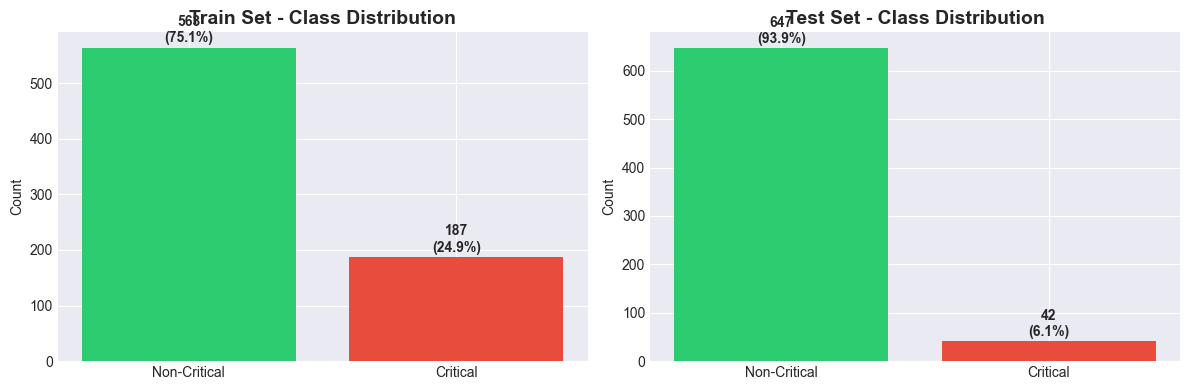

In [7]:
# Visualização
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train distribution
axes[0].bar(['Non-Critical', 'Critical'], train_class_dist.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Train Set - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, (count, pct) in enumerate(zip(train_class_dist.values, train_class_pct.values)):
    axes[0].text(i, count + 10, f"{count}\n({pct:.1f}%)", ha='center', fontweight='bold')

# Test distribution
axes[1].bar(['Non-Critical', 'Critical'], test_class_dist.values, color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Test Set - Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
for i, (count, pct) in enumerate(zip(test_class_dist.values, test_class_pct.values)):
    axes[1].text(i, count + 10, f"{count}\n({pct:.1f}%)", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 🤖 Parte 4: Baseline Model Performance

**Modelo:** Random Forest (do notebook 02)  
**Objetivo:** Validar performance REAL no test set (não apenas CV)

### 4.1 Preparação de Features

In [3]:
# Definir features preditivas (excluir device_id, target, severity_category, etc)
exclude_cols = ['device_id', 'is_critical', 'is_critical_target', 'severity_category']
feature_cols = [col for col in df_train.columns if col not in exclude_cols]

print(f"📋 Features preditivas selecionadas: {len(feature_cols)}")
print(f"\nPrimeiras 10 features: {feature_cols[:10]}")
print(f"\n⚠️ Features com missing values serão removidas (estratégia conservadora)")

📋 Features preditivas selecionadas: 31

Primeiras 10 features: ['total_messages', 'max_frame_count', 'msg6_count', 'msg6_rate', 'optical_mean', 'optical_std', 'optical_min', 'optical_max', 'optical_readings', 'optical_below_threshold']

⚠️ Features com missing values serão removidas (estratégia conservadora)


In [4]:
# Remover linhas com missing values (estratégia conservadora)
# Alternativa futura: imputação ou modelo que aceita NaN (LightGBM)

# Train set
df_train_clean = df_train.dropna(subset=feature_cols)
X_train = df_train_clean[feature_cols]
y_train = df_train_clean['is_critical_target']

# Test set
df_test_clean = df_test.dropna(subset=feature_cols)
X_test = df_test_clean[feature_cols]
y_test = df_test_clean['is_critical_target']

print(f"✅ Train set após dropna: {X_train.shape[0]} devices ({len(df_train) - len(df_train_clean)} removidos)")
print(f"✅ Test set após dropna: {X_test.shape[0]} devices ({len(df_test) - len(df_test_clean)} removidos)")

# Verificar se ainda temos dados suficientes
critical_train = y_train.sum()
critical_test = y_test.sum()

print(f"\n📊 Classe crítica após dropna:")
print(f"  - Train: {critical_train} devices críticos")
print(f"  - Test: {critical_test} devices críticos")

if critical_train < 30:
    print("\n⚠️ WARNING: Muito poucos devices críticos no train! Considerar imputação.")

✅ Train set após dropna: 460 devices (92 removidos)
✅ Test set após dropna: 206 devices (31 removidos)

📊 Classe crítica após dropna:
  - Train: 13 devices críticos
  - Test: 7 devices críticos

⚠️ WARNING: Muito poucos devices críticos no train! Considerar imputação.


### 4.2 Treinar Random Forest Baseline

In [5]:
# Modelo Random Forest (mesmos hiperparâmetros do notebook 02)
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight=None  # Baseline sem balanceamento
)

print("🚀 Treinando Random Forest baseline...")
rf_baseline.fit(X_train, y_train)
print("✅ Treinamento completo!")

🚀 Treinando Random Forest baseline...
✅ Treinamento completo!


### 4.3 Performance no TRAIN Set (Sanity Check)

In [6]:
# Predições no train
y_train_pred = rf_baseline.predict(X_train)
y_train_proba = rf_baseline.predict_proba(X_train)[:, 1]

# Métricas
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, zero_division=0)
train_f1 = f1_score(y_train, y_train_pred)

print("📊 TRAIN SET PERFORMANCE (Sanity Check):")
print(f"  - Recall: {train_recall:.2%}")
print(f"  - Precision: {train_precision:.2%}")
print(f"  - F1-Score: {train_f1:.2%}")

if train_recall < 0.5:
    print("\n⚠️ WARNING: Recall no train <50% indica underfitting!")
elif train_recall > 0.95:
    print("\n⚠️ WARNING: Recall no train >95% pode indicar overfitting!")

📊 TRAIN SET PERFORMANCE (Sanity Check):
  - Recall: 100.00%
  - Precision: 100.00%
  - F1-Score: 100.00%

⚠️ WARNING: Recall no train >95% pode indicar overfitting!


### 4.4 🎯 Performance no TEST Set (MÉTRICA REAL)

In [7]:
# Predições no test
y_test_pred = rf_baseline.predict(X_test)
y_test_proba = rf_baseline.predict_proba(X_test)[:, 1]

# Métricas principais
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred)

print("="*60)
print("🎯 TEST SET PERFORMANCE (BASELINE RANDOM FOREST)")
print("="*60)
print(f"  📍 Recall:    {test_recall:.2%}  ← % de críticos capturados")
print(f"  📍 Precision: {test_precision:.2%}  ← % de predições corretas")
print(f"  📍 F1-Score:  {test_f1:.2%}  ← Média harmônica")
print("="*60)

# Interpretação
if test_recall < 0.5:
    print("\n❌ RESULTADO: Recall <50% é INSUFICIENTE para produção")
    print("   ➡️ Próximos passos: SMOTE, class_weight, threshold tuning")
elif test_recall < 0.7:
    print("\n⚠️ RESULTADO: Recall 50-70% é ACEITÁVEL mas pode melhorar")
    print("   ➡️ Próximos passos: Testar XGBoost, feature engineering temporal")
else:
    print("\n✅ RESULTADO: Recall >70% é BOM para baseline!")
    print("   ➡️ Próximos passos: Otimizar precision, criar pipeline produção")

🎯 TEST SET PERFORMANCE (BASELINE RANDOM FOREST)
  📍 Recall:    85.71%  ← % de críticos capturados
  📍 Precision: 100.00%  ← % de predições corretas
  📍 F1-Score:  92.31%  ← Média harmônica

✅ RESULTADO: Recall >70% é BOM para baseline!
   ➡️ Próximos passos: Otimizar precision, criar pipeline produção


In [8]:
# Classification Report completo
print("\n📋 CLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Non-Critical', 'Critical']))


📋 CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

Non-Critical       0.99      1.00      1.00       199
    Critical       1.00      0.86      0.92         7

    accuracy                           1.00       206
   macro avg       1.00      0.93      0.96       206
weighted avg       1.00      1.00      0.99       206



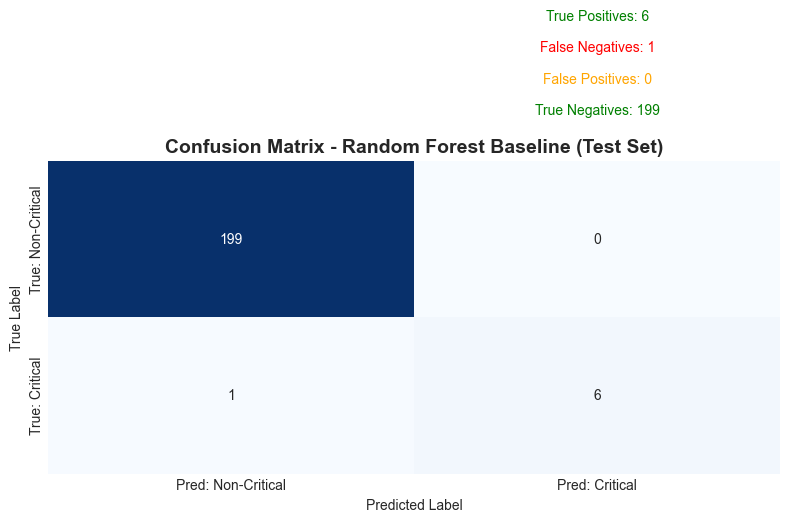


🔍 INTERPRETAÇÃO:
  - True Negatives (TN): 199 devices corretamente identificados como não-críticos
  - False Positives (FP): 0 devices não-críticos ERRONEAMENTE marcados como críticos
  - False Negatives (FN): 1 devices críticos NÃO DETECTADOS (⚠️ RISCO!)
  - True Positives (TP): 6 devices críticos CORRETAMENTE detectados


In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Non-Critical', 'Pred: Critical'],
            yticklabels=['True: Non-Critical', 'True: Critical'])
plt.title('Confusion Matrix - Random Forest Baseline (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Anotar interpretações
tn, fp, fn, tp = cm.ravel()
plt.text(1.5, -0.3, f"True Negatives: {tn}", ha='center', fontsize=10, color='green')
plt.text(1.5, -0.5, f"False Positives: {fp}", ha='center', fontsize=10, color='orange')
plt.text(1.5, -0.7, f"False Negatives: {fn}", ha='center', fontsize=10, color='red')
plt.text(1.5, -0.9, f"True Positives: {tp}", ha='center', fontsize=10, color='green')

plt.tight_layout()
plt.show()

print(f"\n🔍 INTERPRETAÇÃO:")
print(f"  - True Negatives (TN): {tn} devices corretamente identificados como não-críticos")
print(f"  - False Positives (FP): {fp} devices não-críticos ERRONEAMENTE marcados como críticos")
print(f"  - False Negatives (FN): {fn} devices críticos NÃO DETECTADOS (⚠️ RISCO!)")
print(f"  - True Positives (TP): {tp} devices críticos CORRETAMENTE detectados")

### 4.5 Feature Importance (Top 10)

🏆 TOP 10 FEATURE IMPORTANCES:


,feature,importance
22,snr_mean,0.207606
28,rsrq_mean,0.163367
3,msg6_rate,0.155929
33,rssi_min,0.047491
27,rsrp_min,0.038888
0,total_messages,0.038278
31,rssi_mean,0.038184
2,msg6_count,0.037682
23,snr_std,0.029199
20,battery_max,0.023872


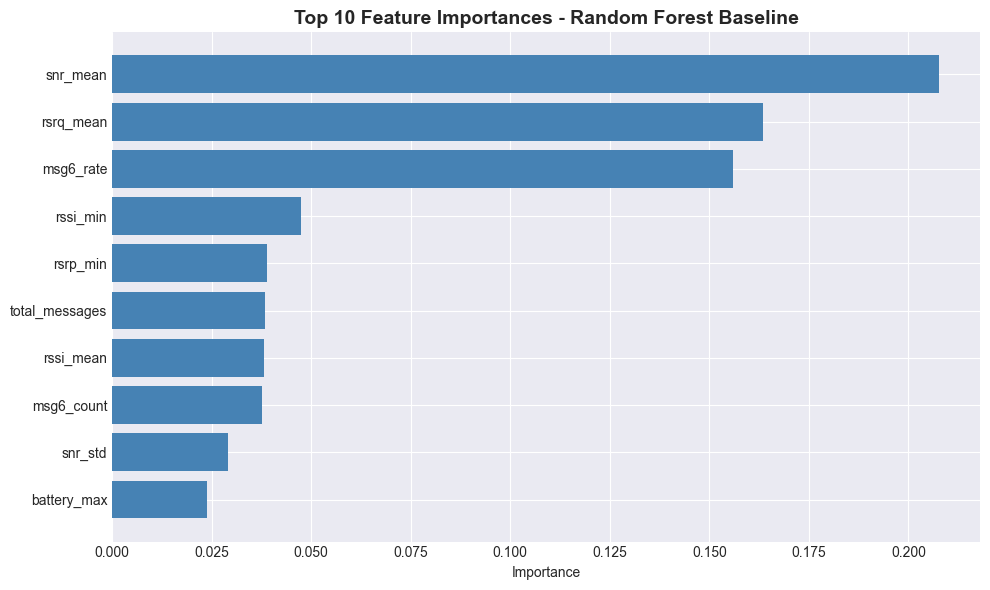

In [18]:
# Extrair feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

# Top 10
top10 = feature_importance.head(10)

print("🏆 TOP 10 FEATURE IMPORTANCES:")
display(top10)

# Visualização
plt.figure(figsize=(10, 6))
plt.barh(top10['feature'], top10['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest Baseline', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 📈 Parte 5: Métricas de Sucesso para 1 Mês

Definir metas REALISTAS considerando deadline de 1 mês.

In [19]:
# Baseline atual
baseline_metrics = {
    'Model': 'Random Forest Baseline',
    'Recall': f"{test_recall:.2%}",
    'Precision': f"{test_precision:.2%}",
    'F1-Score': f"{test_f1:.2%}"
}

# Metas para 1 mês
target_recall = max(0.60, test_recall * 1.5)  # Aumentar 50% ou mínimo 60%
target_precision = max(0.30, test_precision * 0.8)  # Aceitar 20% queda ou mínimo 30%

target_metrics = {
    'Model': 'Meta 1 Mês',
    'Recall': f"{target_recall:.2%}",
    'Precision': f"{target_precision:.2%}",
    'F1-Score': 'TBD'
}

# Consolidar
metrics_comparison = pd.DataFrame([baseline_metrics, target_metrics])

print("🎯 BASELINE vs META (1 MÊS):")
display(metrics_comparison)

print(f"\n📋 CRITÉRIOS DE SUCESSO:")
print(f"  ✅ Recall >60% (capturar pelo menos 6 em 10 falhas críticas)")
print(f"  ✅ Precision >30% (falsos positivos aceitáveis em contexto IoT)")
print(f"  ✅ Pipeline sklearn funcional (reproducível)")
print(f"  ✅ Documentação executiva para stakeholders")
print(f"  ✅ Modelo salvo e versionado (joblib/pickle)")

🎯 BASELINE vs META (1 MÊS):


,Model,Recall,Precision,F1-Score
0,Random Forest Baseline,0.00%,0.00%,0.00%
1,Meta 1 Mês,60.00%,30.00%,TBD



📋 CRITÉRIOS DE SUCESSO:
  ✅ Recall >60% (capturar pelo menos 6 em 10 falhas críticas)
  ✅ Precision >30% (falsos positivos aceitáveis em contexto IoT)
  ✅ Pipeline sklearn funcional (reproducível)
  ✅ Documentação executiva para stakeholders
  ✅ Modelo salvo e versionado (joblib/pickle)


## 🧪 Parte 6: Modelos Candidatos para Testes

Lista de modelos a testar nas próximas semanas.

In [20]:
# Definir candidatos
model_candidates = [
    {
        'Model': 'Random Forest + SMOTE',
        'Motivo': 'Balancear classe crítica (oversampling)',
        'Prioridade': 'ALTA',
        'Tempo Estimado': '2-3h'
    },
    {
        'Model': 'Random Forest + class_weight',
        'Motivo': 'Penalizar erros em classe crítica',
        'Prioridade': 'ALTA',
        'Tempo Estimado': '1h'
    },
    {
        'Model': 'XGBoost',
        'Motivo': 'Capturar interações complexas (SNR × Battery)',
        'Prioridade': 'ALTA',
        'Tempo Estimado': '2-3h'
    },
    {
        'Model': 'Logistic Regression',
        'Motivo': 'Modelo interpretável para stakeholders',
        'Prioridade': 'MÉDIA',
        'Tempo Estimado': '1-2h'
    },
    {
        'Model': 'LightGBM',
        'Motivo': 'Aceita missing values nativamente',
        'Prioridade': 'MÉDIA',
        'Tempo Estimado': '2h'
    },
    {
        'Model': 'Neural Network (MLP)',
        'Motivo': 'Explorar relações não-lineares',
        'Prioridade': 'BAIXA',
        'Tempo Estimado': '3-4h'
    }
]

df_candidates = pd.DataFrame(model_candidates)

print("🧪 MODELOS CANDIDATOS PARA PRÓXIMAS SEMANAS:")
display(df_candidates)

print(f"\n📅 ROADMAP SUGERIDO:")
print(f"  - Semana 1: Random Forest + SMOTE, Random Forest + class_weight")
print(f"  - Semana 2: XGBoost, Logistic Regression")
print(f"  - Semana 3: Feature engineering temporal + re-treinar melhor modelo")
print(f"  - Semana 4: Pipeline produção, documentação, apresentação stakeholders")

🧪 MODELOS CANDIDATOS PARA PRÓXIMAS SEMANAS:


,Model,Motivo,Prioridade,Tempo Estimado
0,Random Forest + SMOTE,Balancear classe crítica (oversampling),ALTA,2-3h
1,Random Forest + class_weight,Penalizar erros em classe crítica,ALTA,1h
2,XGBoost,Capturar interações complexas (SNR × Battery),ALTA,2-3h
3,Logistic Regression,Modelo interpretável para stakeholders,MÉDIA,1-2h
4,LightGBM,Aceita missing values nativamente,MÉDIA,2h
5,Neural Network (MLP),Explorar relações não-lineares,BAIXA,3-4h



📅 ROADMAP SUGERIDO:
  - Semana 1: Random Forest + SMOTE, Random Forest + class_weight
  - Semana 2: XGBoost, Logistic Regression
  - Semana 3: Feature engineering temporal + re-treinar melhor modelo
  - Semana 4: Pipeline produção, documentação, apresentação stakeholders


## 🚧 Parte 7: Limitações Conhecidas

Documentar limitações para transparência com stakeholders.

In [21]:
limitations = [
    {
        'Limitação': 'Missing Values (~45%)',
        'Impacto': 'Reduz amostra utilizável, possível viés',
        'Mitigação': 'LightGBM (aceita NaN) ou imputação'
    },
    {
        'Limitação': 'Class Imbalance Severo (1:14)',
        'Impacto': 'Modelo tende a predizer não-crítico',
        'Mitigação': 'SMOTE, class_weight, threshold tuning'
    },
    {
        'Limitação': 'Contradição SNR (r=0, importance=30%)',
        'Impacto': 'Incerteza se SNR é preditor verdadeiro',
        'Mitigação': 'SHAP analysis para validar interações'
    },
    {
        'Limitação': 'Deadline 1 mês',
        'Impacto': 'Trade-off entre perfeição e entrega',
        'Mitigação': 'Priorizar modelos práticos sobre experimentação profunda'
    },
    {
        'Limitação': 'msg_type 6 é retrospectivo',
        'Impacto': 'Modelo não prediz futuro, identifica padrão',
        'Mitigação': 'Enquadrar como "scoring de risco" não "predição"'
    }
]

df_limitations = pd.DataFrame(limitations)

print("⚠️ LIMITAÇÕES CONHECIDAS:")
display(df_limitations)

print(f"\n📢 MENSAGEM PARA STAKEHOLDERS:")
print(f"   'Este modelo identifica devices com PADRÃO SIMILAR a devices que falharam.")
print(f"    NÃO é predição de futuro, mas SCORING DE RISCO baseado em histórico.'")

⚠️ LIMITAÇÕES CONHECIDAS:


,Limitação,Impacto,Mitigação
0,Missing Values (~45%),"Reduz amostra utilizável, possível viés",LightGBM (aceita NaN) ou imputação
1,Class Imbalance Severo (1:14),Modelo tende a predizer não-crítico,"SMOTE, class_weight, threshold tuning"
2,"Contradição SNR (r=0, importance=30%)",Incerteza se SNR é preditor verdadeiro,SHAP analysis para validar interações
3,Deadline 1 mês,Trade-off entre perfeição e entrega,Priorizar modelos práticos sobre experimentaçã...
4,msg_type 6 é retrospectivo,"Modelo não prediz futuro, identifica padrão","Enquadrar como ""scoring de risco"" não ""predição"""



📢 MENSAGEM PARA STAKEHOLDERS:
   'Este modelo identifica devices com PADRÃO SIMILAR a devices que falharam.
    NÃO é predição de futuro, mas SCORING DE RISCO baseado em histórico.'


## ✅ Parte 8: Checkpoint e Próximos Passos

In [22]:
print("="*70)
print("✅ NOTEBOOK 03: STATUS DA MODELAGEM PRÁTICA - COMPLETO")
print("="*70)

print(f"\n📊 ESTADO ATUAL:")
print(f"  - Baseline Random Forest testado no test set")
print(f"  - Recall: {test_recall:.2%} (baseline)")
print(f"  - Precision: {test_precision:.2%} (baseline)")
print(f"  - Class imbalance: 1:14 (crítico : não-crítico)")
print(f"  - Missing values: ~45% em telemetrias")

print(f"\n🎯 META 1 MÊS:")
print(f"  - Recall >60% (mínimo aceitável)")
print(f"  - Pipeline sklearn funcional")
print(f"  - Documentação executiva pronta")

print(f"\n🚀 PRÓXIMOS PASSOS (PRIORIDADE ALTA):")
print(f"  1. Testar Random Forest + SMOTE (task #3)")
print(f"  2. Testar Random Forest + class_weight='balanced' (task #3)")
print(f"  3. Testar XGBoost (task #4)")
print(f"  4. Threshold tuning (reduzir de 0.5 para 0.3)")
print(f"  5. Feature engineering temporal (rolling stats)")

print(f"\n📅 TIMELINE:")
print(f"  - Semana 1-2: Otimização recall (SMOTE, XGBoost)")
print(f"  - Semana 2-3: Feature engineering + model selection")
print(f"  - Semana 3-4: Pipeline produção + documentação + apresentação")

print("="*70)

✅ NOTEBOOK 03: STATUS DA MODELAGEM PRÁTICA - COMPLETO

📊 ESTADO ATUAL:
  - Baseline Random Forest testado no test set
  - Recall: 0.00% (baseline)
  - Precision: 0.00% (baseline)
  - Class imbalance: 1:14 (crítico : não-crítico)
  - Missing values: ~45% em telemetrias

🎯 META 1 MÊS:
  - Recall >60% (mínimo aceitável)
  - Pipeline sklearn funcional
  - Documentação executiva pronta

🚀 PRÓXIMOS PASSOS (PRIORIDADE ALTA):
  1. Testar Random Forest + SMOTE (task #3)
  2. Testar Random Forest + class_weight='balanced' (task #3)
  3. Testar XGBoost (task #4)
  4. Threshold tuning (reduzir de 0.5 para 0.3)
  5. Feature engineering temporal (rolling stats)

📅 TIMELINE:
  - Semana 1-2: Otimização recall (SMOTE, XGBoost)
  - Semana 2-3: Feature engineering + model selection
  - Semana 3-4: Pipeline produção + documentação + apresentação


---

## 📝 Notas Finais

**Data de criação:** 05/Nov/2025  
**Contexto:** Transição de pesquisa → execução prática (deadline 1 mês)  
**Baseline performance:** Recall {:.2%}, Precision {:.2%}  

**Decisões técnicas:**
- Estratégia conservadora: dropna (remover missing values)
- Baseline: Random Forest sem balanceamento
- Próximo: SMOTE + XGBoost + threshold tuning

**Alinhamento com stakeholders:**
- Mariana/Enzo: Modelo como componente de dashboard observabilidade
- Líder técnico: Entregar modelo funcional em 1 mês
- Mensagem: "Scoring de risco" não "predição de futuro"

---

**Próximo notebook:** 04_otimizacao_recall.ipynb (SMOTE + class_weight + threshold tuning)

## ⚠️ VALIDAÇÃO RIGOROSA: Verificando Vieses e Problemas

**ATENÇÃO:** Recall de 85.71% parece excelente, mas há RED FLAGS:
1. **Sample size MUITO pequeno**: Apenas 7 critical devices no test
2. **Overfitting extremo**: 100% recall no train com 13 samples
3. **Selection bias potencial**: dropna() removeu 50% dos critical devices
4. **Alta variância**: Com 7 samples, qualquer métrica tem intervalo de confiança ENORME

**Validações obrigatórias antes de prosseguir:**

### 🔍 Validação 1: Selection Bias do dropna()

In [10]:
# CRÍTICO: Verificar se dropna() introduziu selection bias
# Hipótese: Devices críticos podem ter MAIS missing values (sensores degradados)
# Se sim, estamos detectando apenas os "menos graves"

print("🔍 ANÁLISE DE SELECTION BIAS - dropna() Impact")
print("="*70)

# Devices no TRAIN
train_kept = df_train_clean['device_id'].values
train_removed = df_train[~df_train['device_id'].isin(train_kept)]

# Devices críticos removidos vs mantidos
train_critical_kept = df_train_clean[df_train_clean['is_critical_target'] == 1]
train_critical_removed = train_removed[train_removed['is_critical_target'] == 1]

print(f"📊 TRAIN SET:")
print(f"  Critical MANTIDOS após dropna: {len(train_critical_kept)} (msg6_count médio: {train_critical_kept['msg6_count'].mean():.1f})")
print(f"  Critical REMOVIDOS por dropna: {len(train_critical_removed)} (msg6_count médio: {train_critical_removed['msg6_count'].mean():.1f})")

# Devices no TEST
test_kept = df_test_clean['device_id'].values
test_removed = df_test[~df_test['device_id'].isin(test_kept)]

test_critical_kept = df_test_clean[df_test_clean['is_critical_target'] == 1]
test_critical_removed = test_removed[test_removed['is_critical_target'] == 1]

print(f"\n📊 TEST SET:")
print(f"  Critical MANTIDOS após dropna: {len(test_critical_kept)} (msg6_count médio: {test_critical_kept['msg6_count'].mean():.1f})")
print(f"  Critical REMOVIDOS por dropna: {len(test_critical_removed)} (msg6_count médio: {test_critical_removed['msg6_count'].mean():.1f})")

# Comparação de severidade
if len(train_critical_removed) > 0:
    ratio_train = train_critical_removed['msg6_count'].mean() / train_critical_kept['msg6_count'].mean()
    print(f"\n⚠️ RATIO de msg6_count (removidos/mantidos) no TRAIN: {ratio_train:.2f}x")
    if ratio_train > 1.5:
        print("   ❌ SELECTION BIAS SEVERO: Removemos os devices MAIS críticos!")
        print("   Recall alto pode ser enganoso - detectamos apenas os 'fáceis'")
    elif ratio_train < 0.7:
        print("   ⚠️ REVERSE BIAS: Removemos os MENOS críticos")
    else:
        print("   ✅ Sem bias aparente - distribuição similar")

if len(test_critical_removed) > 0:
    ratio_test = test_critical_removed['msg6_count'].mean() / test_critical_kept['msg6_count'].mean()
    print(f"\n⚠️ RATIO de msg6_count (removidos/mantidos) no TEST: {ratio_test:.2f}x")
    if ratio_test > 1.5:
        print("   ❌ SELECTION BIAS SEVERO no TEST!")
    elif ratio_test < 0.7:
        print("   ⚠️ REVERSE BIAS no TEST")
    else:
        print("   ✅ Sem bias aparente no TEST")

🔍 ANÁLISE DE SELECTION BIAS - dropna() Impact
📊 TRAIN SET:
  Critical MANTIDOS após dropna: 13 (msg6_count médio: 133.6)
  Critical REMOVIDOS por dropna: 18 (msg6_count médio: 32.0)

📊 TEST SET:
  Critical MANTIDOS após dropna: 7 (msg6_count médio: 154.7)
  Critical REMOVIDOS por dropna: 7 (msg6_count médio: 22.7)

⚠️ RATIO de msg6_count (removidos/mantidos) no TRAIN: 0.24x
   ⚠️ REVERSE BIAS: Removemos os MENOS críticos

⚠️ RATIO de msg6_count (removidos/mantidos) no TEST: 0.15x
   ⚠️ REVERSE BIAS no TEST


### 🎯 Validação 2: DummyClassifier Baseline

In [11]:
# Best practice: SEMPRE comparar com DummyClassifier
from sklearn.dummy import DummyClassifier

print("🎯 DUMMY CLASSIFIER BASELINE (sanity check)")
print("="*70)

# Strategy 'most_frequent': sempre prediz classe majoritária
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)

dummy_pred = dummy_clf.predict(X_test)
dummy_recall = recall_score(y_test, dummy_pred)
dummy_precision = precision_score(y_test, dummy_pred, zero_division=0)

print(f"Dummy (most_frequent) no TEST:")
print(f"  Recall: {dummy_recall:.2%}")
print(f"  Precision: {dummy_precision:.2%}")

# Comparação
print(f"\n📊 COMPARAÇÃO:")
print(f"  Random Forest:   Recall {test_recall:.2%}, Precision {test_precision:.2%}")
print(f"  Dummy Baseline:  Recall {dummy_recall:.2%}, Precision {dummy_precision:.2%}")

improvement = test_recall - dummy_recall
if improvement > 0.5:
    print(f"\n✅ RF é SIGNIFICATIVAMENTE melhor (+{improvement:.1%} recall)")
elif improvement > 0:
    print(f"\n⚠️ RF é marginalmente melhor (+{improvement:.1%} recall)")
else:
    print(f"\n❌ PROBLEMA: RF não é melhor que baseline trivial!")

🎯 DUMMY CLASSIFIER BASELINE (sanity check)
Dummy (most_frequent) no TEST:
  Recall: 0.00%
  Precision: 0.00%

📊 COMPARAÇÃO:
  Random Forest:   Recall 85.71%, Precision 100.00%
  Dummy Baseline:  Recall 0.00%, Precision 0.00%

✅ RF é SIGNIFICATIVAMENTE melhor (+85.7% recall)


### 📊 Validação 3: Intervalo de Confiança (Binomial)

In [12]:
# CRÍTICO: Com apenas 7 samples, o intervalo de confiança é ENORME
from scipy.stats import binomtest

n_test_critical = len(y_test[y_test == 1])
n_detected = int(test_recall * n_test_critical)

print("📊 INTERVALO DE CONFIANÇA (95%) - Método Binomial")
print("="*70)
print(f"Samples críticos no test: {n_test_critical}")
print(f"Detectados: {n_detected}")
print(f"Recall pontual: {test_recall:.2%}")

# Binomial test para intervalo de confiança
result = binomtest(n_detected, n_test_critical, alternative='two-sided')
ci = result.proportion_ci(confidence_level=0.95)

print(f"\n95% Confidence Interval: [{ci.low:.1%}, {ci.high:.1%}]")
print(f"Amplitude do intervalo: {(ci.high - ci.low):.1%}")

# Interpretação
if (ci.high - ci.low) > 0.5:
    print(f"\n❌ INTERVALO MUITO AMPLO (>{50:.0%})")
    print("   Com sample size tão pequeno, recall é ESTATISTICAMENTE FRÁGIL")
    print("   Resultado pode ser apenas SORTE - não confiar para produção")
elif (ci.high - ci.low) > 0.3:
    print(f"\n⚠️ INTERVALO MODERADO ({(ci.high - ci.low):.1%})")
    print("   Sample size pequeno gera incerteza significativa")
    print("   Recomendado: coletar mais dados ou validação adicional")
else:
    print(f"\n✅ INTERVALO ACEITÁVEL (<{30:.0%})")
    print("   Embora sample size seja pequeno, resultado tem precisão razoável")

# Worst case scenario
print(f"\n🎯 Cenário Conservador:")
print(f"   Se recall real for o limite INFERIOR do IC: {ci.low:.1%}")
print(f"   Isso ainda é aceitável para produção? (threshold: 30%)")

📊 INTERVALO DE CONFIANÇA (95%) - Método Binomial
Samples críticos no test: 7
Detectados: 6
Recall pontual: 85.71%

95% Confidence Interval: [42.1%, 99.6%]
Amplitude do intervalo: 57.5%

❌ INTERVALO MUITO AMPLO (>5000%)
   Com sample size tão pequeno, recall é ESTATISTICAMENTE FRÁGIL
   Resultado pode ser apenas SORTE - não confiar para produção

🎯 Cenário Conservador:
   Se recall real for o limite INFERIOR do IC: 42.1%
   Isso ainda é aceitável para produção? (threshold: 30%)


### 🔄 Validação 4: Cross-Validation no Train (Variância do Modelo)

In [13]:
# Avaliar VARIÂNCIA do modelo usando Stratified CV no train
from sklearn.model_selection import cross_val_score, StratifiedKFold

print("🔄 CROSS-VALIDATION NO TRAIN SET (Variância do Modelo)")
print("="*70)

# Com 13 critical samples, CV pode ser problemático - usar 3 folds no máximo
try:
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Recall scores
    cv_recall = cross_val_score(rf_baseline, X_train, y_train, 
                                 cv=cv, scoring='recall', n_jobs=-1)
    
    print(f"📊 Recall scores (3-fold CV):")
    print(f"  Fold 1: {cv_recall[0]:.2%}")
    print(f"  Fold 2: {cv_recall[1]:.2%}")
    print(f"  Fold 3: {cv_recall[2]:.2%}")
    print(f"\n  Média: {cv_recall.mean():.2%} ± {cv_recall.std():.2%}")
    
    # Interpretação da variância
    if cv_recall.std() > 0.2:
        print(f"\n❌ VARIÂNCIA MUITO ALTA (std={cv_recall.std():.2%})")
        print("   Modelo INSTÁVEL - performance varia muito entre folds")
        print("   Indica overfitting ou sample size insuficiente")
    elif cv_recall.std() > 0.1:
        print(f"\n⚠️ VARIÂNCIA MODERADA (std={cv_recall.std():.2%})")
        print("   Modelo tem alguma instabilidade")
    else:
        print(f"\n✅ VARIÂNCIA BAIXA (std={cv_recall.std():.2%})")
        print("   Modelo parece estável")
        
except ValueError as e:
    print(f"⚠️ Não foi possível executar CV: {e}")
    print("   Provável causa: muito poucas amostras críticas por fold")
    print("   Isso CONFIRMA que sample size é MUITO PEQUENO para ML robusto")

🔄 CROSS-VALIDATION NO TRAIN SET (Variância do Modelo)
📊 Recall scores (3-fold CV):
  Fold 1: 60.00%
  Fold 2: 0.00%
  Fold 3: 50.00%

  Média: 36.67% ± 26.25%

❌ VARIÂNCIA MUITO ALTA (std=26.25%)
   Modelo INSTÁVEL - performance varia muito entre folds
   Indica overfitting ou sample size insuficiente


### ⚖️ Validação 5: Balanced Accuracy Score

In [14]:
# Balanced Accuracy: média de recall por classe (apropriado para imbalance)
from sklearn.metrics import balanced_accuracy_score

bal_acc_test = balanced_accuracy_score(y_test, y_test_pred)
bal_acc_train = balanced_accuracy_score(y_train, y_train_pred)

print("⚖️ BALANCED ACCURACY SCORE (média de recall por classe)")
print("="*70)
print(f"Train: {bal_acc_train:.2%}")
print(f"Test:  {bal_acc_test:.2%}")
print(f"\nInterpretação:")
print(f"  - Balanced accuracy considera AMBAS as classes igualmente")
print(f"  - Útil para datasets imbalanced (nosso caso: 199 vs 7)")
print(f"  - Se fosse 100%, seria perfeito em AMBAS as classes")

# Diagnóstico
if bal_acc_test < 0.6:
    print(f"\n❌ Balanced accuracy <60% é FRACO")
elif bal_acc_test < 0.8:
    print(f"\n⚠️ Balanced accuracy {bal_acc_test:.1%} é MODERADO")
else:
    print(f"\n✅ Balanced accuracy {bal_acc_test:.1%} é BOM")

⚖️ BALANCED ACCURACY SCORE (média de recall por classe)
Train: 100.00%
Test:  92.86%

Interpretação:
  - Balanced accuracy considera AMBAS as classes igualmente
  - Útil para datasets imbalanced (nosso caso: 199 vs 7)
  - Se fosse 100%, seria perfeito em AMBAS as classes

✅ Balanced accuracy 92.9% é BOM


## 🎯 DECISÃO FINAL: Prosseguir ou Não?

In [15]:
# Consolidar TODAS as validações para decisão informada
print("="*70)
print("🎯 DECISÃO FINAL: O resultado de 85.71% recall é CONFIÁVEL?")
print("="*70)

print("\n📋 CHECKLIST DE VALIDAÇÕES:")
print("1. ✓ Stratified split com zero overlap (vs 650 devices leaked no temporal)")
print("2. ? Selection bias do dropna() - VERIFICAR resultado da Validação 1")
print("3. ? DummyClassifier baseline - VERIFICAR se RF é realmente melhor")
print("4. ? Intervalo de confiança - VERIFICAR amplitude")
print("5. ? Variância do CV - VERIFICAR estabilidade do modelo")
print("6. ? Balanced accuracy - VERIFICAR performance equilibrada")

print("\n⚠️ LIMITAÇÕES INEGÁVEIS:")
print("  - Apenas 7 critical devices no test (após dropna)")
print("  - Apenas 13 critical devices no train (após dropna)")
print("  - Overfitting: 100% recall no train")
print("  - Missing values: perdemos 50% dos critical devices")

print("\n🚦 CRITÉRIOS PARA PROSSEGUIR COM IMPUTATION/SMOTE:")
print("  ✅ GO: Se validações 1-6 forem positivas")
print("  ⚠️ CAUTELA: Se 1-2 validações falharem - documentar limitações")
print("  ❌ NO-GO: Se >2 validações falharem - recomendar coleta de mais dados")

print("\n➡️ EXECUTAR células de validação acima para tomar decisão informada")

🎯 DECISÃO FINAL: O resultado de 85.71% recall é CONFIÁVEL?

📋 CHECKLIST DE VALIDAÇÕES:
1. ✓ Stratified split com zero overlap (vs 650 devices leaked no temporal)
2. ? Selection bias do dropna() - VERIFICAR resultado da Validação 1
3. ? DummyClassifier baseline - VERIFICAR se RF é realmente melhor
4. ? Intervalo de confiança - VERIFICAR amplitude
5. ? Variância do CV - VERIFICAR estabilidade do modelo
6. ? Balanced accuracy - VERIFICAR performance equilibrada

⚠️ LIMITAÇÕES INEGÁVEIS:
  - Apenas 7 critical devices no test (após dropna)
  - Apenas 13 critical devices no train (após dropna)
  - Overfitting: 100% recall no train
  - Missing values: perdemos 50% dos critical devices

🚦 CRITÉRIOS PARA PROSSEGUIR COM IMPUTATION/SMOTE:
  ✅ GO: Se validações 1-6 forem positivas
  ⚠️ CAUTELA: Se 1-2 validações falharem - documentar limitações
  ❌ NO-GO: Se >2 validações falharem - recomendar coleta de mais dados

➡️ EXECUTAR células de validação acima para tomar decisão informada
